## Introduction

These models were created because in the Production Model notebook, it was observed that there is a linear relationship between the number of words an example has and the chance it will be predicted correctly.  Three models are created here that manipulates the input data to increase the number of words per example.  The goal here is to train a base model (taken from the Production Model notebook) with less sparse vectors in the hope that it performs better.

The `LimitWordCount` model limits training to only examples that are above a mimimum word count.

The `ExampleSmuhingModel` model concatenates adjacent examples of the same class until each example satisfies a minimum word count.  The data put into here is not shuffled, so each example ends up being the character's dialogue over a longer scene from the movie.

The `MaximumSmushingModel` model takes smushing to the extreme and concatenates examples of the same class into one massive example.

## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import clone

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Data Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

#np.random.seed(RANDOM_SEED)
#mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
0,0,TONY STARK,"Oh, I get it. You guys aren’t allowed to talk. Is that it? Are you not allowed to talk?",Iron Man,2008,22,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False
1,2,TONY STARK,Oh. I see. So it’s personal.,Iron Man,2008,8,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False
2,4,TONY STARK,"Good God, you’re a woman. I, honestly, I couldn’t have called that. I would apologize, but isn’t that what we’re going for here? I saw you as a soldier first.",Iron Man,2008,31,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False
3,6,TONY STARK,Please.,Iron Man,2008,1,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False
4,8,TONY STARK,"Excellent question. Yes and no. March and I had a schedule conflict but, thankfully, the Christmas cover was twins. Anyone else? You, with the hand up.",Iron Man,2008,28,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Oh, I get it.  You guys aren’t allowed to talk.  Is that it?  Are you not allowed to talk?',
        'Oh.  I see.  So it’s personal.',
        'Good God, you’re a woman. I, honestly, I couldn’t have called that. I would apologize, but isn’t that what we’re going for here? I saw you as a soldier first. ',
        'Please.',
        'Excellent question. Yes and no. March and I had a schedule conflict but, thankfully, the Christmas cover was twins.  Anyone else? You, with the hand up. ',
        'Join the club.',
        'Are you aware that Native Americans believe photographs steal a little piece of your soul?  Not to worry, mine’s long gone. Fire away.',
        'GET DOWN, TONY.  GET THE --',
        'As Program Manager and Liaison to Stark Industries, I’ve had the honor of serving with a real patriot, a man whose life has been dedicated to protecting our troops on the front lines.  He’s a friend. And a great mentor.  A man who has always been there for his friends and his coun

## Models

In [5]:
cross_validator = StratifiedKFold(n_splits=5, shuffle=False)
score_method = "balanced_accuracy"

In [6]:
class LimitWordCountModel(BaseEstimator):
    '''
    Trains and predicts base model, but restricts training to examples 
    that contain more words than the given threshold.
    '''
    def __init__(self, base_model, min_word_count):
        self.base_model = base_model
        self.model = None
        self.min_word_count = min_word_count
    
    def fit(self, X, y):
        self.model = clone(self.base_model)
        example_indices = np.array([len(i) for i in np.char.split(X, " ")]) > self.min_word_count
        self.model.fit(X[example_indices], y[example_indices])
    
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model has not yet been fitted, unable to predict.")
        return self.model.predict(X)

In [7]:
class ExampleSmushingModel(BaseEstimator):
    '''
    Groups examples together so that every example satisfies a minimum word count.
    Trains / predicts using the base_model on this new set.
    '''
    def __init__(self, base_model, min_word_count):
        self.base_model = base_model
        self.model = None
        self.min_word_count = min_word_count

    def fit(self, X, y):
        set_ = pd.DataFrame({"character": y, "line": X})
        set_['line'] = set_['line'].str.replace(" {2,3}", " ", regex=True)
        joined_set = set_.groupby(['character'])['line'].apply(lambda x: ' '.join(x)).reset_index()

        def smush(lst):
            result_list = []
            temp_string = ""
            for i in range(0,len(lst)):
                temp_string = temp_string + " " + lst[i]

                if (i+1) % self.min_word_count == 0:
                    result_list.append(temp_string)
                    temp_string = ""

            if len(lst) % self.min_word_count > 0:
                result_list.append(temp_string)

            return result_list

        smushed_series = joined_set['line'].str.split(" ").apply(smush)
        smushed_series.index = joined_set['character']

        result_set = pd.DataFrame(columns=["line", 'character'])
        for i in range(0,len(smushed_series)):
            result_set = pd.concat([result_set, pd.DataFrame({"line": pd.Series(smushed_series[i]), "character": smushed_series.index[i]})])
        
        self.model = clone(self.base_model)
        self.model.fit(result_set['line'].to_numpy().astype(str), result_set['character'].to_numpy().astype(str))
    
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model has not yet been fitted, unable to predict.")
        return self.model.predict(X)

In [8]:
class MaximumSmushingModel(BaseEstimator):
    '''
    Groups every example by class into one example per class
    and trains / predicts with base_model on that set.
    '''
    def __init__(self, base_model):
        self.base_model = base_model
        self.model = None
    
    def fit(self, X, y):
        set_ = pd.DataFrame({"character": y, "line": X})
        joined_set = set_.groupby(['character'])['line'].apply(lambda x: ' '.join(x)).reset_index()
        self.model = clone(self.base_model)
        self.model.fit(joined_set['line'].to_numpy().astype(str), joined_set['character'].to_numpy().astype(str))

    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model has not yet been fitted, unable to predict.")
        return self.model.predict(X)

In [9]:
base_model = Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

# 50 is the number of words where the regression line in Production Models gives 0.75 accuracy
model16 = LimitWordCountModel(base_model, 50)
model17 = ExampleSmushingModel(base_model, 50)
model18 = MaximumSmushingModel(base_model)

## Nested CV Balanced Accuracy

In [10]:
models = {"model 16": model16, "model 17": model17, "model 18": model18}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.0s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.3

,model 16,model 17,model 18
fold,,,
0,0.147505,0.204509,0.224671
1,0.152461,0.236471,0.272885
2,0.168833,0.266150,0.276682
3,0.119875,0.215608,0.222429
4,0.147076,0.213312,0.204214
mean,0.147150,0.227210,0.240176
std,0.015763,0.022114,0.029159
max,0.168833,0.266150,0.276682


## Confusion Matrix (Model 18)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.3s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s finished


Balanced Accuracy: 0.24010973996170631
Balanced Accuracy: 0.24010973996170631


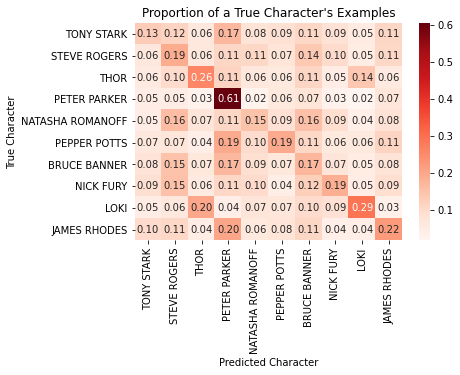

In [11]:
yhat = cross_val_predict(model18, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [12]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls

,recall
PETER PARKER,0.606171
LOKI,0.290520
THOR,0.258401
JAMES RHODES,0.223270
PEPPER POTTS,0.194570
STEVE ROGERS,0.191402
NICK FURY,0.185792
BRUCE BANNER,0.171504
NATASHA ROMANOFF,0.148594
TONY STARK,0.130872


## Conclusion

These models did not perform better than the Production Model, which means that they won't be used.